In [1]:
%matplotlib inline

In [2]:
import nengo
import matplotlib.pyplot as plt
import numpy as np
import nengo_spa as spa

# Number of dimensions for the SPs
dimensions = 256

# Change the seed of this RNG to change the vocabulary
rng = np.random.RandomState(1)

In [3]:
def CleanUp(vector, vocab):
    """
    Returns the semantic pointer in the vocabulary that is most similar to the given vector.
    
    Args:
    - vector (np.ndarray): A vector representing a semantic pointer.
    - vocab (spa.Vocabulary): The vocabulary to search for the most similar semantic pointer.
    
    Returns:
    - str: The key of the semantic pointer in the vocab that is most similar to the input vector.
    """
    # Compute dot products between the input vector and all vectors in the vocabulary
    similarities = {key: np.dot(vector, vocab[key].v) for key in vocab.keys()}
    
    # Find the key with the highest dot product (most similar)
    most_similar = max(similarities, key=similarities.get)
    
    return most_similar

In [4]:
# Decode and plot similarities
def PlotSimilarity(item, vocab):
    slots = ['NAME', 'REL', 'HAIR', 'FRUIT']
    fig, axes = plt.subplots(1, len(slots), figsize=(14.5, 3.5))

    for i, slot in enumerate(slots):
        slot_vector = vocab.parse(f"~{slot}*{item}").normalized()
        similarities = [np.dot(slot_vector.v, vocab[key].v) for key in vocab.keys()]

        axes[i].bar(vocab.keys(), similarities, width=0.5)
        axes[i].set_title(f'Similarities for decoding "{slot}"')
        axes[i].set_ylabel('Dot Product Similarity')
        axes[i].set_xlabel('Vocabulary Items')
        # axes[i].tick_params(axis='x', rotation=45)
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    plt.tight_layout()
    plt.show()

In [5]:
# Decode and plot only name similarity, saving space in paper
def PlotNameSim(item, vocab):
    name_vector = vocab.parse(f"~NAME*{item}").normalized()
    name_sim = [np.dot(name_vector.v, vocab[key].v) for key in vocab.keys()]

    plt.figure(figsize=(4,3.5))
    plt.bar(vocab.keys(), name_sim, width=0.5)
    plt.title(f'Similarities for decoding "NAME"')
    plt.ylabel('Dot Product Similarity')
    plt.xlabel('Vocabulary Items')
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    plt.tight_layout()
    plt.show()

In [6]:
def RecallName(item, names, threshold):
    unbind_name = vocab.parse(f"~NAME*{item}").normalized()
    # print(f"{unbind_name.v}")

    name_similarities = {key: np.dot(unbind_name.v, names[key].v) for key in names.keys()}
    print(name_similarities)
    
    # retrieve max sim value and corresponding key:
    most_similar_name = max(name_similarities, key=name_similarities.get)
    most_similar_name_vec = max(name_similarities.values())
    
    # if name is recalled smile, else frown:
    if most_similar_name_vec < threshold:
        print("Frown. I don't recall her name.")
    else:
        print(f"Smile. Her name is {most_similar_name}.")

In [7]:
# if girls are similar, they might be mistaken
def GirlSim(source, target):
    for girl_id in target:
        similarity = np.dot(source.v, target[girl_id].v)
        print(f"Dot product similarity of {source} to {girl_id} is {similarity}")

In [8]:
vocab = spa.Vocabulary(dimensions, pointer_gen=rng)

# Add the required words to the vocabulary
words = ["NAME", "SWANN", "CHLOE", "ANAIS", "REL", "NEIGHBOUR", "HAIR", "BROWN", 
         "SISTER_OF", "FRUIT", "APPLE", "BANANA"]
vocab.populate(";".join(words))

In [9]:
# On the first interaction, one of the properties is the name
vocab.populate("GIRL_52 = (NAME * SWANN + REL * NEIGHBOUR + HAIR * BROWN + FRUIT * APPLE).normalized()")
# another neighbour:
vocab.populate("GIRL_53 = (NAME * ANAIS + REL * NEIGHBOUR + HAIR * BROWN + FRUIT * BANANA).normalized()")
# Swann's sister Chloé is similar to Swann:
vocab.populate("GIRL_54 = (GIRL_52 + SISTER_OF + NAME * CHLOE).normalized()")

In [10]:
# create a vocab of names
vocab_name = vocab.create_subset(["SWANN", "CHLOE", "ANAIS"])
# set "forgetting threshold"
recall_threshold = 0.3

In [11]:
# create list of girl_ids to compare to GIRL_52
vocab_girl_ids = vocab.create_subset(["GIRL_53", "GIRL_54"]) 

In [12]:
GirlSim(vocab["GIRL_52"], vocab_girl_ids)

Dot product similarity of SemanticPointer<GIRL_52> to GIRL_53 is 0.5480544208205451
Dot product similarity of SemanticPointer<GIRL_52> to GIRL_54 is 0.5942699475844838


In [13]:
RecallName("GIRL_52", vocab_name, recall_threshold)

{'SWANN': 0.38092398751158374, 'CHLOE': 0.007039564099104334, 'ANAIS': 0.14108842445328418}
Smile. Her name is SWANN.


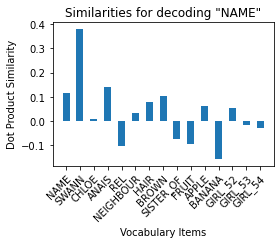

In [14]:
PlotNameSim("GIRL_52", vocab)

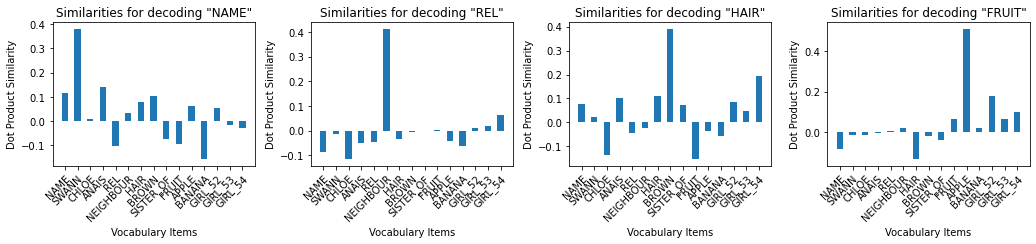

In [15]:
PlotSimilarity("GIRL_52", vocab)
# PlotSimilarity("GIRL_53", vocab)

In [16]:
# On subsequent interactions, name is not provided

for i in range(2):
    E1 = vocab.parse('REL * NEIGHBOUR + HAIR * BROWN + FRUIT * APPLE').normalized()
    #E1 = vocab.parse('REL * BROWN').normalized()
    most_similar_E1 = CleanUp(E1.v, vocab)
    print(vocab[most_similar_E1])
    updated_E1 = E1.v + vocab[most_similar_E1].v
    vocab._vectors[vocab._key2idx[most_similar_E1]] = updated_E1/np.linalg.norm(updated_E1)

# Generate and normalize E2
E2 = vocab.parse('FRUIT * APPLE').normalized()
most_similar_E2 = CleanUp(E2.v, vocab)
print(f"most similar to E2: {vocab[most_similar_E2]}")
updated_E2 = E2.v + vocab[most_similar_E2].v
vocab._vectors[vocab._key2idx[most_similar_E2]] = updated_E2/np.linalg.norm(updated_E2)

SemanticPointer<GIRL_52>
SemanticPointer<GIRL_52>
most similar to E2: SemanticPointer<GIRL_52>


In [17]:
RecallName("GIRL_52", vocab_name, recall_threshold)

{'SWANN': 0.06550169907481798, 'CHLOE': 0.013557900770409331, 'ANAIS': 0.14902629077770796}
Frown. I don't recall her name.


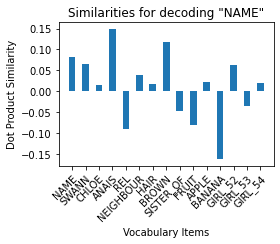

In [18]:
PlotNameSim("GIRL_52", vocab)

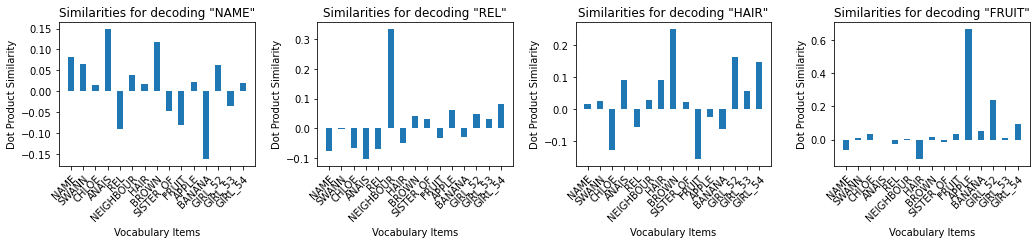

In [19]:
PlotSimilarity("GIRL_52", vocab)

In [20]:
# hear name of GIRL_52 again at E3
# GIRL_52 has favourite fruit as distinguishing feature
E3 = vocab.parse('NAME * SWANN + FRUIT * APPLE').normalized()
most_similar_E3 = CleanUp(E3.v, vocab)
print(f"most similar to E3: {vocab[most_similar_E3]}")
updated_E3 = E3.v + vocab[most_similar_E3].v
vocab._vectors[vocab._key2idx[most_similar_E3]] = updated_E3/np.linalg.norm(updated_E3)

most similar to E3: SemanticPointer<GIRL_52>


In [21]:
GirlSim(vocab["GIRL_52"], vocab_girl_ids)

Dot product similarity of SemanticPointer<GIRL_52> to GIRL_53 is 0.28290625831328753
Dot product similarity of SemanticPointer<GIRL_52> to GIRL_54 is 0.5025275749950151


In [22]:
RecallName("GIRL_52", vocab_name, recall_threshold)

{'SWANN': 0.3598461067661446, 'CHLOE': -0.017625008687702573, 'ANAIS': 0.1323118256180993}
Smile. Her name is SWANN.


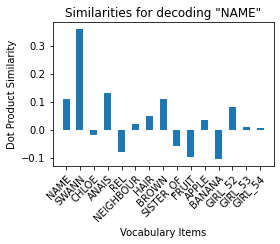

In [23]:
PlotNameSim("GIRL_52", vocab)

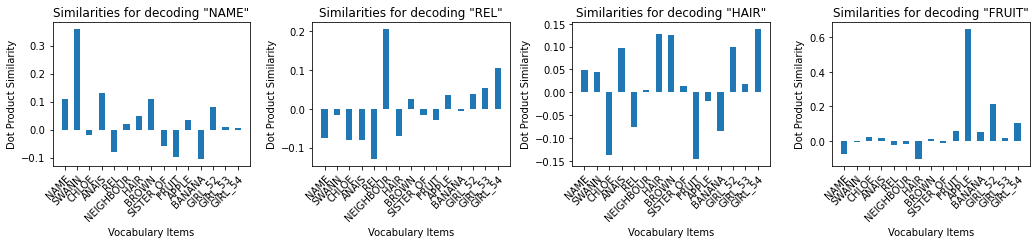

In [24]:
PlotSimilarity("GIRL_52", vocab)